# VAR Model

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller

In [20]:
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
ipe_df['contTime'] = pd.to_datetime(ipe_df.contTime)
data = ipe_df.drop(['contTime'], axis=1)
data.index = ipe_df.contTime

In [22]:
ipe_daily = data.resample('D').mean()

In [23]:
ipe_daily = ipe_daily[:'2022-08-01']

In [24]:
ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1, inplace=True)

In [25]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [26]:
#missing value treatment
cols = ipe_interp.columns
for j in cols:
    for i in range(0,len(data)):
       if data[j][i] == -200:
           data[j][i] = data[j][i-1]

#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = ipe_interp.drop(['Turb_FNU'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

array([2.15220082e-01, 1.80611416e-01, 2.29809820e-02, 1.74034320e-03,
       2.41081711e-05])

In [27]:
#creating the train and validation set
train = ipe_interp[:int(0.8*(len(ipe_interp)))]
valid = ipe_interp[int(0.8*(len(ipe_interp))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

In [28]:
ipe_interp

,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
contTime,,,,,,
2014-06-20,2.282571,0.343889,-0.009167,6.402500,13.020333,98.772222
2014-06-21,2.491979,0.366667,-0.003125,6.491563,12.617740,97.936458
2014-06-22,2.760521,0.370417,-0.002396,6.799479,12.587917,98.336458
2014-06-23,3.366875,0.427187,0.011667,6.973333,12.869354,100.618750
2014-06-24,4.185000,0.578438,0.051042,6.847812,12.998385,104.945833
...,...,...,...,...,...,...
2022-07-28,4.219896,0.428229,0.047188,6.822292,19.556458,156.690625
2022-07-29,3.899583,0.438333,0.048646,6.774479,19.535104,157.709375
2022-07-30,3.379583,0.413229,0.047708,6.654688,19.576562,158.085417


In [29]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,6):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for Turb_FNU is :  2.7383659272172762
rmse value for Chloro_RFU is :  6.877909512269996
rmse value for BGA_RFU is :  2.3694970332552323
rmse value for ODO_mgL is :  1.1449593541254703
rmse value for Temp_C is :  7.257233782153503
rmse value for Cond_muSCm is :  18.235399753372032


In [34]:
#make final predictions
model = VAR(endog=data.dropna())
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.endog, steps=365)
print(yhat)

[[  1.23113043   1.50222136   2.19110486 ...   7.50393294   8.71233199
  101.70674981]
 [  1.44200416   1.57462497   2.42442725 ...   9.73551146   8.3340359
  106.46396491]
 [  1.47572961   1.56816106   2.34351711 ...  11.5944137    7.99527785
  111.53238651]
 ...
 [  3.04050699   3.07798021   3.56211756 ...  10.6782423    7.69766542
  124.95836316]
 [  3.04050699   3.07798021   3.56211756 ...  10.6782423    7.69766542
  124.95836316]
 [  3.04050699   3.07798021   3.56211756 ...  10.6782423    7.69766542
  124.95836316]]


C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


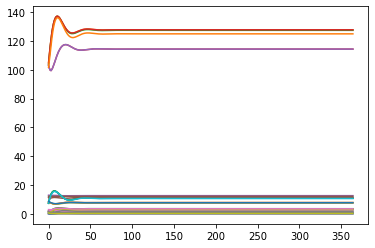

In [37]:
plt.plot(yhat)